# **Flower Detection using CNN**
we will be using the CNN for detecting the flowers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL

from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers, losses, callbacks
from keras.models import Sequential


In [2]:
data_dir= '../input/flowers-recognition/flowers/flowers'

In [3]:
batch_size=32
img_height= 180
img_width= 180

In [4]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [5]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [6]:
class_names= train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

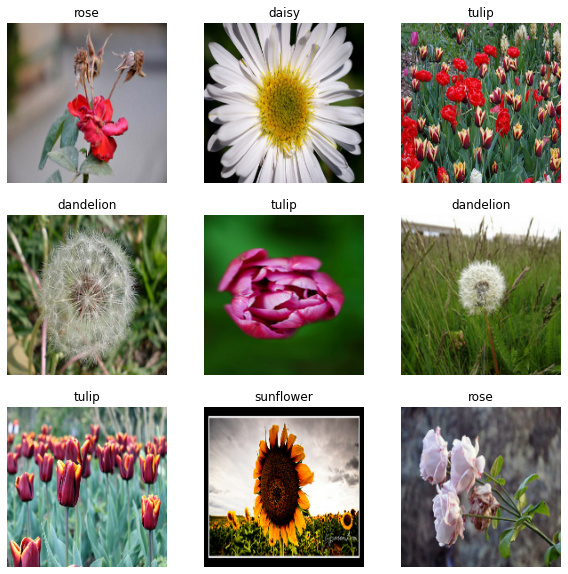

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
# configuring the dataset for performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# standardizing the data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [14]:
from keras.callbacks import EarlyStopping
callback= EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=True)

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=callback
)

Epoch 1/10
109/109 [==============================] - 32s 72ms/step - loss: 1.5377 - accuracy: 0.3426 - val_loss: 1.0502 - val_accuracy: 0.5961
Epoch 2/10
109/109 [==============================] - 2s 14ms/step - loss: 1.0019 - accuracy: 0.6112 - val_loss: 1.1287 - val_accuracy: 0.5602
Epoch 3/10
109/109 [==============================] - 2s 15ms/step - loss: 0.8463 - accuracy: 0.6756 - val_loss: 0.9478 - val_accuracy: 0.6181
Epoch 4/10
109/109 [==============================] - 2s 14ms/step - loss: 0.6269 - accuracy: 0.7708 - val_loss: 1.0103 - val_accuracy: 0.6042
Epoch 5/10
109/109 [==============================] - 2s 14ms/step - loss: 0.4432 - accuracy: 0.8435 - val_loss: 1.0724 - val_accuracy: 0.6296
Epoch 6/10
109/109 [==============================] - 2s 14ms/step - loss: 0.2512 - accuracy: 0.9250 - val_loss: 1.3419 - val_accuracy: 0.6250
Epoch 7/10
109/109 [==============================] - 2s 14ms/step - loss: 0.1564 - accuracy: 0.9528 - val_loss: 1.7228 - val_accuracy: 0.597

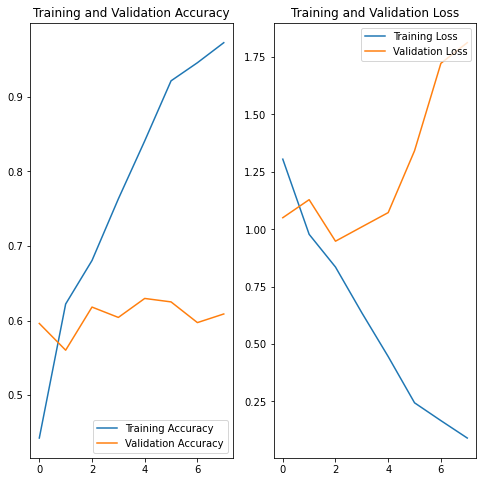

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

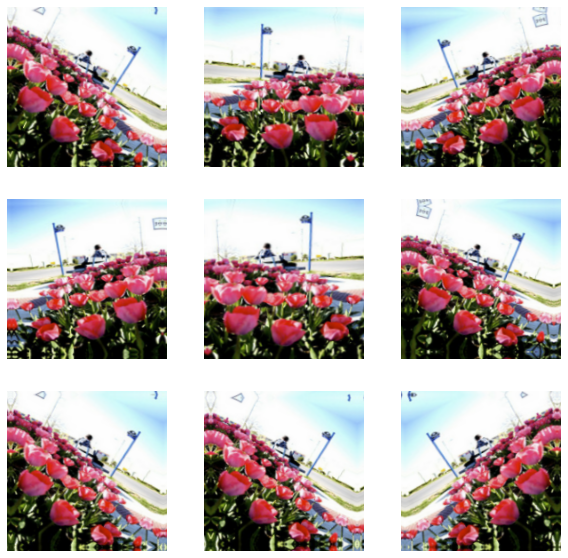

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
109/109 [==============================] - 3s 19ms/step - loss: 1.5782 - accuracy: 0.3294 - val_loss: 1.1648 - val_accuracy: 0.4884
Epoch 2/15
109/109 [==============================] - 2s 17ms/step - loss: 1.0656 - accuracy: 0.5542 - val_loss: 1.0751 - val_accuracy: 0.5486
Epoch 3/15
109/109 [==============================] - 2s 17ms/step - loss: 0.9569 - accuracy: 0.6313 - val_loss: 1.0065 - val_accuracy: 0.6111
Epoch 4/15
109/109 [==============================] - 2s 17ms/step - loss: 0.8683 - accuracy: 0.6674 - val_loss: 0.9241 - val_accuracy: 0.6308
Epoch 5/15
109/109 [==============================] - 2s 17ms/step - loss: 0.8417 - accuracy: 0.6766 - val_loss: 0.9981 - val_accuracy: 0.6250
Epoch 6/15
109/109 [==============================] - 2s 17ms/step - loss: 0.8252 - accuracy: 0.6811 - val_loss: 1.1020 - val_accuracy: 0.6157
Epoch 7/15
109/109 [==============================] - 2s 18ms/step - loss: 0.7816 - accuracy: 0.7048 - val_loss: 0.9163 - val_accuracy: 0.6470

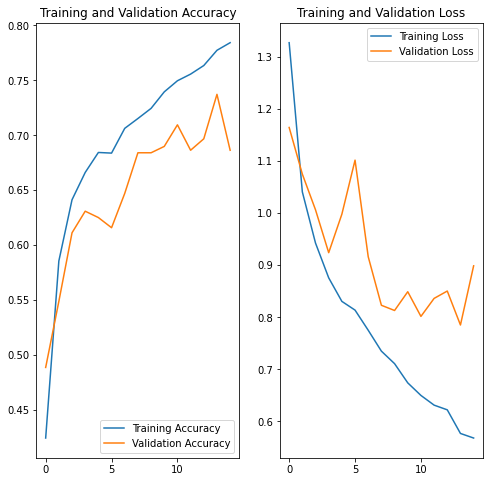

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflower with a 100.00 percent confidence.
